# Air Passenger Data Analysis

## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as ex


## Load the Datasets

In [2]:
data=pd.read_csv("C:/Users/sachi/Downloads/AirPassengers.csv")
print(data)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [3]:
df=pd.DataFrame(data)
print(df)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [5]:
df.set_index('Month',inplace=True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


# Exploratory Data Analysis

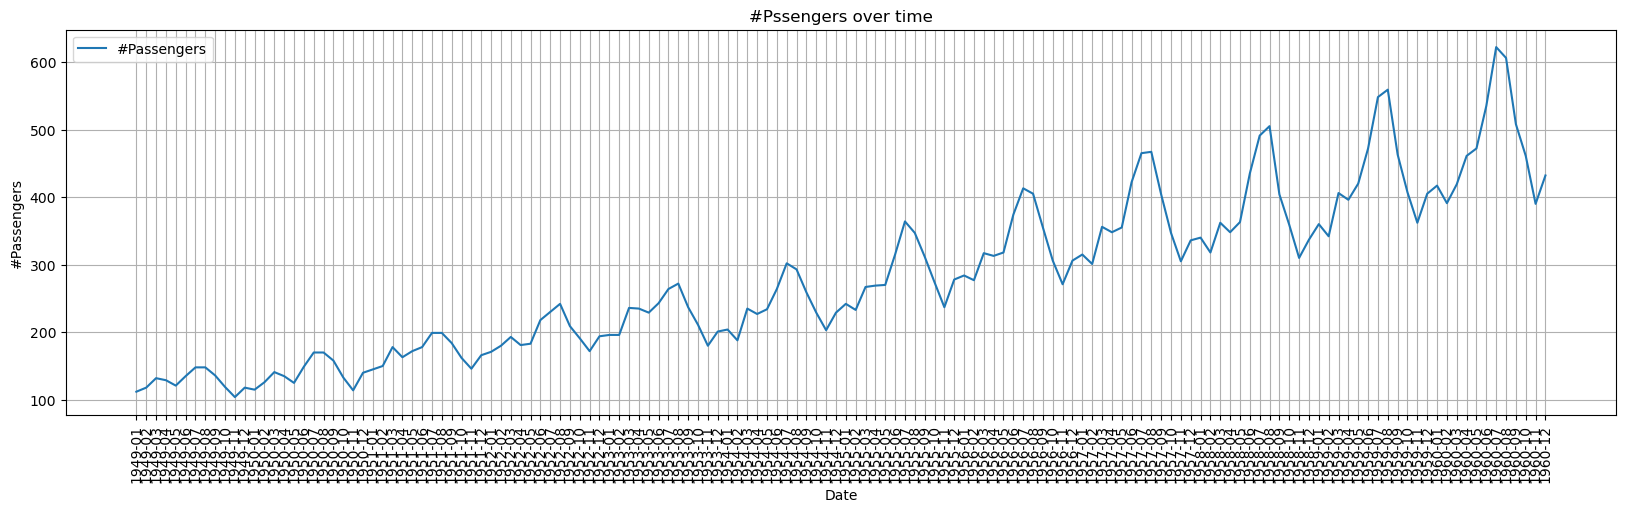

In [9]:
plt.figure(figsize=(20,5))
plt.plot(df.index,df['#Passengers'],label='#Passengers')
plt.xlabel("Date")
plt.ylabel("#Passengers")
plt.title("#Pssengers over time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

## Perform seasonal decompositions

In [23]:
result=seasonal_decompose(df['#Passengers'],model='mutliplicative',period=12)
result.trend


Month
1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
           ..
1960-08   NaN
1960-09   NaN
1960-10   NaN
1960-11   NaN
1960-12   NaN
Name: trend, Length: 144, dtype: float64

## Plot the components in the graph

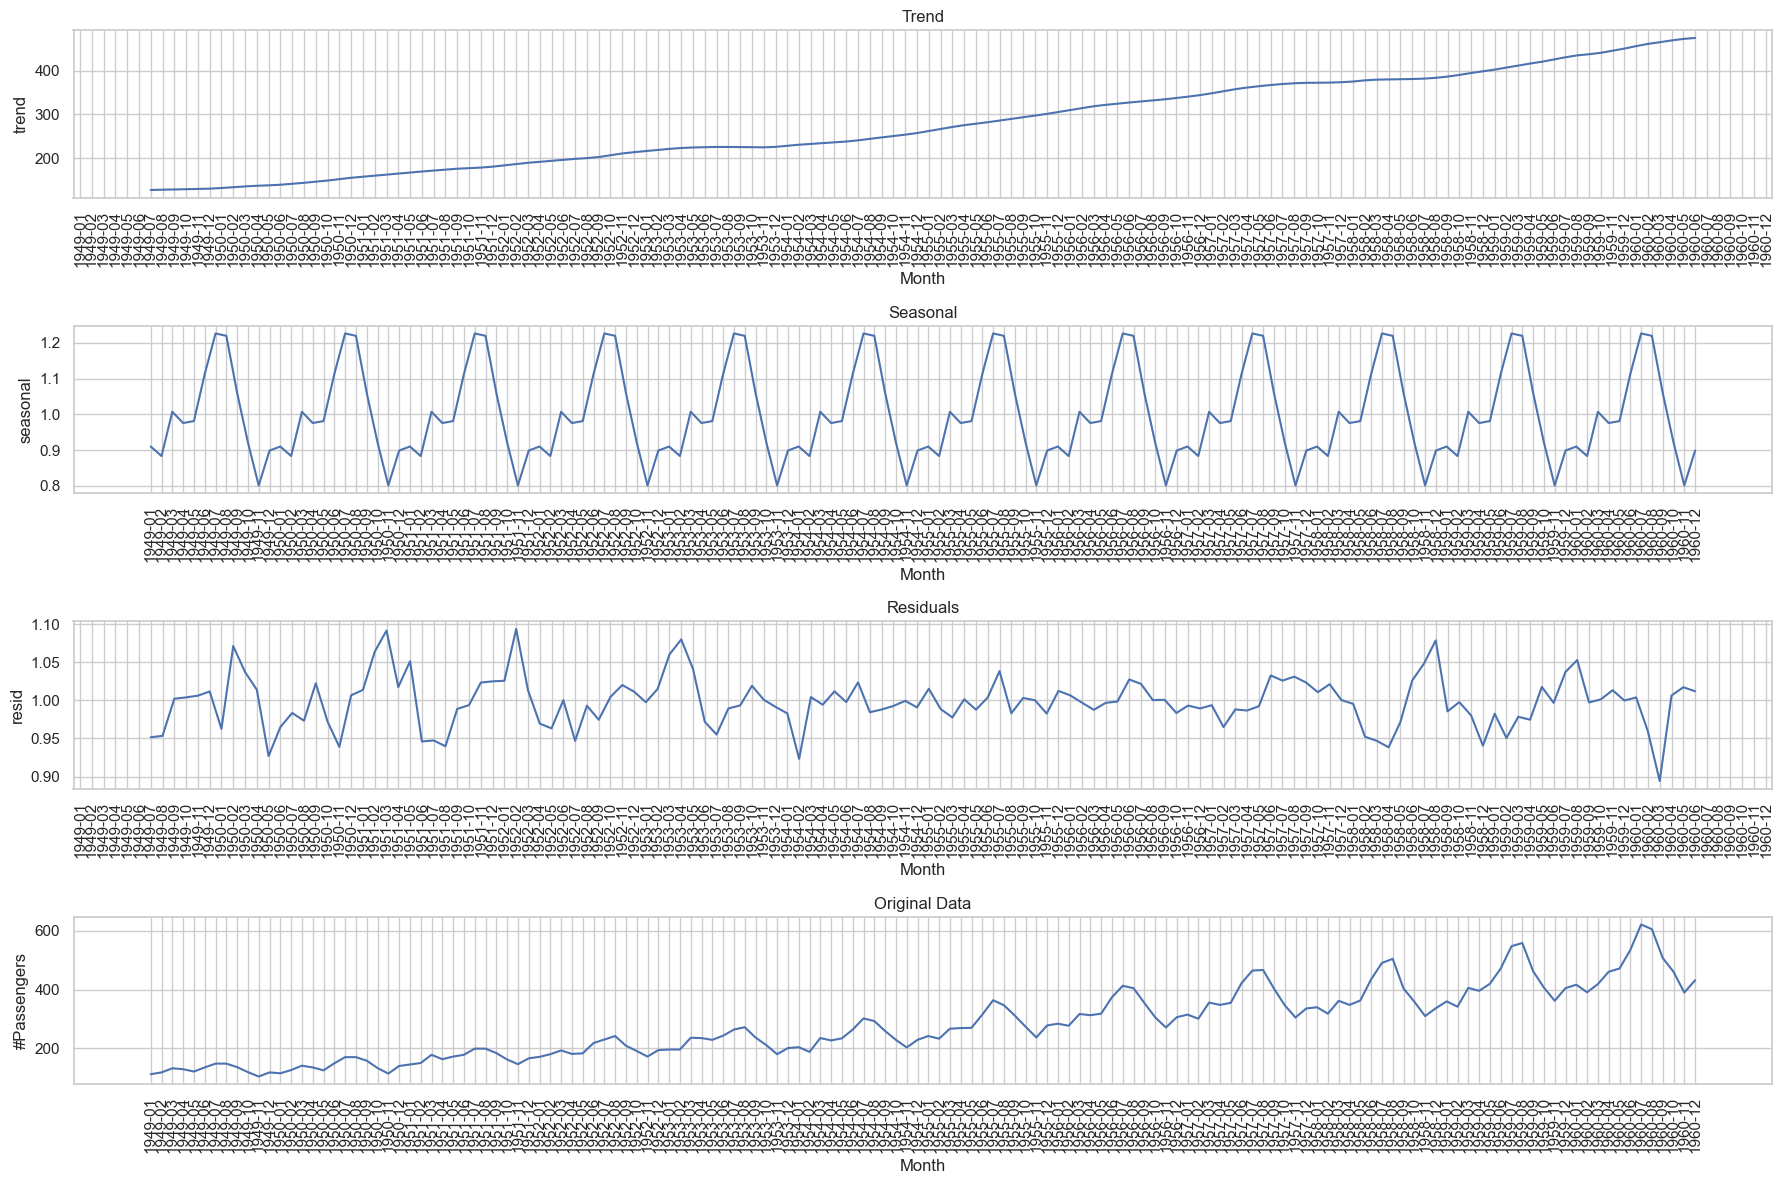

In [26]:
# plot the components in the graph
sns.set(style='whitegrid')

plt.figure(figsize=(18,12))

# trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)

# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)

# Residuals component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)

# Original data
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [27]:
seasonal_period=12


In [28]:
from statsmodels.tsa.stattools import adfuller# augmented dickey fuller test
result=adfuller(df['#Passengers'],autolag='AIC') #Akaike informations criterion
print('ADF Statistic:',result[0])
print('p-value:',result[1])

ADF Statistic: 0.8153688792060547
p-value: 0.9918802434376411


In [30]:
result=adfuller(df['#Passengers'].diff().dropna(),autolag='AIC')
print('ADF Statistic:',result[0])
print('p-vlaue:',result[1])

ADF Statistic: -2.829266824170004
p-vlaue: 0.05421329028382491


In [34]:
# second order differencing
result = adfuller(df['#Passengers'].diff().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.38423154246853
p-value: 2.732891850014085e-29


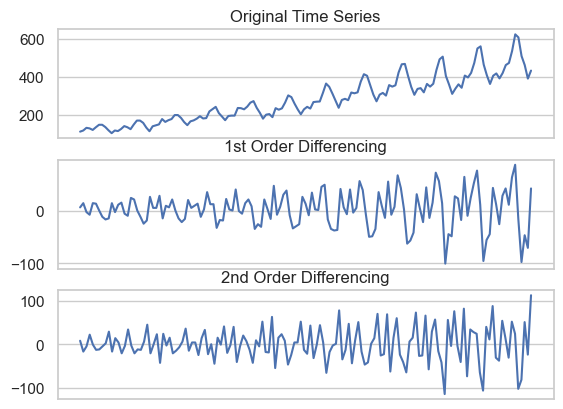

In [35]:
# plot the differencing values
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()

In [36]:
# the time series becomes stationary after first order differencing


In [37]:
# p = 0 # MA - Moving Average - PACF
# d = 1 # order of differencing - I
# q = 0 # AR - Auto Regressive - ACF

AttributeError: module 'statsmodels.graphics' has no attribute 'tsa'

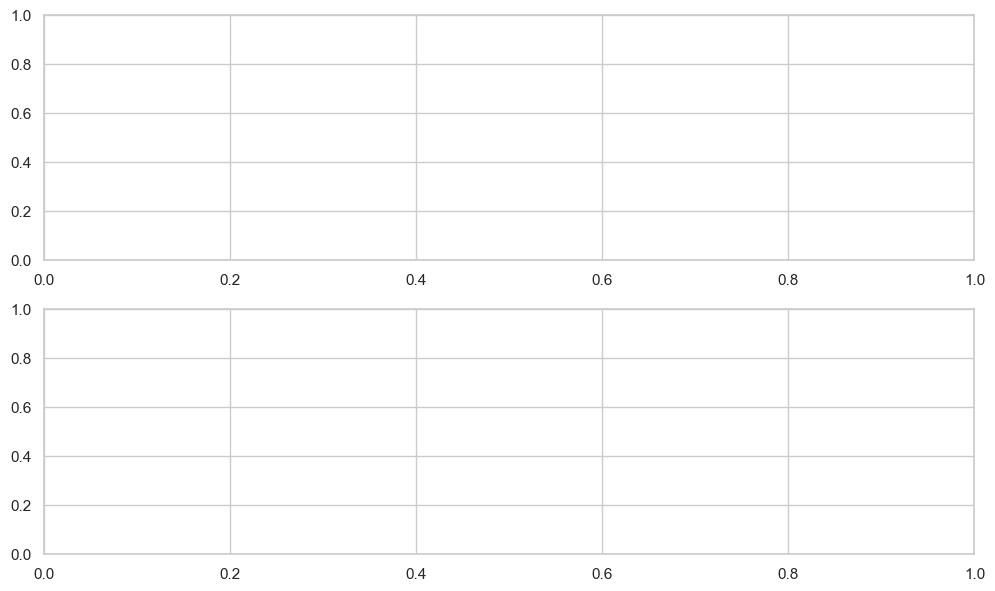

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [40]:
p = 2 # pacf
d = 1 # 1st order difference
q = 1 # acf

In [41]:
P = 1
D = 0
Q = 3

In [42]:
# define the arima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -563.224
Date:                                    Sun, 05 Oct 2025   AIC                           1142.448
Time:                                            11:29:19   BIC                           1166.151
Sample:                                        01-01-1949   HQIC                          1152.080
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6244      0.101      6.170      0

In [43]:
# forecast for next 2 years
forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:].strftime('%Y-%m') # remove start date
# create a forecast dataframe
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:, 0]),
    "Upper CI": list(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

forecast_df.head()


,Forecast,Lower CI,Upper CI
1961-01,446.729983,424.885253,468.574713
1961-02,423.357127,397.221884,449.492369
1961-03,456.475700,426.863351,486.088048
1961-04,491.612441,459.586663,523.638218
1961-05,505.185836,471.311821,539.059852
